# <center>GANomaly</center>

$L_{D}=\log D(x)+\log(1-D(\hat{x})$ \
$L_{G}=L_{adv}+50L_{con}+L_{enc}$ \
推論フェーズ \
$A=MinMaxScaler(|z(x)-\hat{z}(x)|)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

今回使うモデルのサイズと深さを決めておきましょう：

In [2]:
SIZE = 32
DEPTH = 4
DATASET_PATH = './save_weight/GANomaly'

# 1. モデルの作成

ジェネレータはUNetベースなので、もう勉強済みなので実装は簡単。ただ今回はインスタンス規格化を使うので、TensorFlow Addonsをインストールする。

pip install tensorflow-addon

以下の部品は、ほぼ以前のUNetの実装の通り：

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Input

from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.initializers import RandomNormal

gamma_initializer = RandomNormal(mean=0.0, stddev=0.02)

## Generator 

In [4]:
class enc_block(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size, Dropout=False, Maxpool=True):
        super(enc_block, self).__init__()
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.dropout = Dropout
        self.maxpool = Maxpool
        
        self.layer1 = layers.Conv2D(self.n_channels, self.kernel_size, padding='same')
        self.norm1 = InstanceNormalization()
        self.layer2 = layers.Conv2D(self.n_channels, self.kernel_size, padding='same')
        self.norm2 = InstanceNormalization()
        self.maxlayer = layers.MaxPool2D((2,2),padding='same')
        
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.norm1(x)
        x = layers.LeakyReLU(0.2)(x)
        x = self.layer2(x)
        x = self.norm2(x)
        x = layers.LeakyReLU(0.2)(x)
        
        if self.dropout == True:
            x = layers.Dropout(0.5)(x)
        
        if self.maxpool == True:
            x = self.maxlayer(x)

        return x
    
class dec_block(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size):
        super(dec_block, self).__init__()
        self.n_channels = n_channels
        
        self.layer1 = layers.Conv2D(self.n_channels, (2,2), padding='same')
        self.norm1 = InstanceNormalization()
        self.layer2 = layers.Conv2D(self.n_channels, (3,3), padding='same')
        self.norm2 = InstanceNormalization()
        
    def call(self, inputs):
        x = layers.UpSampling2D((2, 2))(inputs)
        x = self.layer1(x)
        x = self.norm1(x)
        x = layers.Activation('relu')(x)
        x = self.layer2(x)
        x = self.norm2(x)
        x = layers.Activation('relu')(x)

        return x

In [5]:
class Encoder(tf.keras.Model):
    def __init__(self, size):
        super(Encoder, self).__init__()
        self.size = size
        self.n_classes = 3
        
        self.encoder1 = enc_block(64, 3)
        self.encoder2 = enc_block(128,3)
        self.encoder3 = enc_block(256,3)
        self.encoder4 = enc_block(512,3,True)
        self.encoder5 = enc_block(1024,3,True,False)
      
    def call(self, inputs):
        
        x = self.encoder1(inputs)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)
        x = self.encoder5(x)
        x = layers.Dropout(0.5)(x)
        
        return x
    
    #Subclass APIでSummaryを作るために利用する関数
    def my_summary(self, input_shape):
        
        tmp_x = Input(shape=input_shape, name='tmp_input')
        tmp_m = Model(inputs=tmp_x, outputs=self.call(tmp_x), name='tmp_model')
        tmp_m.summary()
        del tmp_x, tmp_m

In [6]:
class Decoder(tf.keras.Model):
    def __init__(self, size):
        super(Decoder, self).__init__()
        self.size = size
        self.n_classes = 3
        
        self.decoder1 = dec_block(512,3)
        self.decoder2 = dec_block(256,3)
        self.decoder3 = dec_block(128,3)
        self.decoder4 = dec_block(64,3)
        
        self.last_layer = layers.Conv2D(self.n_classes, (1,1), padding='same', activation='tanh')
        
    def call(self, inputs):
        x = self.decoder1(inputs)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)
        x = self.last_layer(x)

        return x
    
    #Subclass APIでSummaryを作るために利用する関数
    def my_summary(self, input_shape):
        
        tmp_x = Input(shape=input_shape, name='tmp_input')
        tmp_m = Model(inputs=tmp_x, outputs=self.call(tmp_x), name='tmp_model')
        tmp_m.summary()
        del tmp_x, tmp_m

In [7]:
encoder = Encoder(size=(SIZE,SIZE,3))
encoder.my_summary((SIZE,SIZE,3))

Model: "tmp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tmp_input (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
enc_block (enc_block)        (None, 16, 16, 64)        38976     
_________________________________________________________________
enc_block_1 (enc_block)      (None, 8, 8, 128)         221952    
_________________________________________________________________
enc_block_2 (enc_block)      (None, 4, 4, 256)         886272    
_________________________________________________________________
enc_block_3 (enc_block)      (None, 2, 2, 512)         3542016   
_________________________________________________________________
enc_block_4 (enc_block)      (None, 2, 2, 1024)        14161920  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 1024)        0 

In [8]:
decoder = Decoder(size=(2,2,1024))
decoder.my_summary((2,2,1024))

Model: "tmp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tmp_input (InputLayer)       [(None, 2, 2, 1024)]      0         
_________________________________________________________________
dec_block (dec_block)        (None, 4, 4, 512)         4459520   
_________________________________________________________________
dec_block_1 (dec_block)      (None, 8, 8, 256)         1115648   
_________________________________________________________________
dec_block_2 (dec_block)      (None, 16, 16, 128)       279296    
_________________________________________________________________
dec_block_3 (dec_block)      (None, 32, 32, 64)        70016     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 3)         195       
Total params: 5,924,675
Trainable params: 5,924,675
Non-trainable params: 0
_______________________________________________

## Discriminator
latent lossの計算に最後の畳み込み層の出力も必要になるので、シグモイド出力と特徴マップ出力のペアを出力するモデルとした。

In [9]:
class D_conv_block(tf.keras.layers.Layer):
    def __init__(self, kernel_size=(3,3), n_channels=32, norm=True):
        super(D_conv_block,self).__init__()
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.norm = norm
        
        self.layer1 = layers.Conv2D(n_channels, kernel_size, padding='same')
        self.norm1 = InstanceNormalization()
        self.layer2 = layers.Conv2D(n_channels, kernel_size, strides=2, padding='same')
        self.norm2 = InstanceNormalization()
        
    def call(self,inputs):
        x = self.layer1(inputs)
        x = self.norm1(x)
        x = layers.LeakyReLU(0.2)(x)
        x = self.layer2(x)
        
        if self.norm == True:
            x = self.norm2(x)
            
        x = layers.LeakyReLU(0.2)(x)

        return x

In [10]:
class Discriminator(tf.keras.Model):
    def __init__(self, size, kernel_size=(3,3), n_channels=32):
        super(Discriminator, self).__init__()
        self.size = size
        
        self.layer1 = D_conv_block(n_channels=64)
        self.layer2 = D_conv_block(n_channels=128)
        self.layer3 = D_conv_block(n_channels=256)
        self.layer4 = D_conv_block(n_channels=512)
        self.layer5 = D_conv_block(n_channels=100,norm=False)
        self.final = layers.Dense(1)
        
    def call(self,inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        f = self.layer5(x)
        f = layers.Flatten()(f)
        x = self.final(f)
        x = layers.Activation('sigmoid')(x)
        
        return [f, x]
    
    #summaryを表示させるための関数
    def my_summary(self, input_shape=(256,256,1)):
        tmp_x = Input(shape=input_shape, name='tmp_input')
        tmp_m = Model(inputs=tmp_x, outputs=self.call(tmp_x), name='tmp_model')
        tmp_m.summary()
        del tmp_x, tmp_m

In [11]:
discriminator = Discriminator(size=(SIZE,SIZE,3))
discriminator.my_summary((SIZE,SIZE,3))

Model: "tmp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tmp_input (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
d_conv_block (D_conv_block)  (None, 16, 16, 64)        38976     
_________________________________________________________________
d_conv_block_1 (D_conv_block (None, 8, 8, 128)         221952    
_________________________________________________________________
d_conv_block_2 (D_conv_block (None, 4, 4, 256)         886272    
_________________________________________________________________
d_conv_block_3 (D_conv_block (None, 2, 2, 512)         3542016   
_________________________________________________________________
d_conv_block_4 (D_conv_block (None, 1, 1, 100)         551200    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0 

あとで必要になるので、latent lossに使う特徴量の次元を取得しておく：

In [12]:
#latent_dim = discriminator.output[0].shape[1]
latent_dim = 100

In [13]:
optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5, beta_2=0.999)

# 2. 学習の準備

今回のモデルは色々lossがあるので、trainingに使うモデルを工夫しておく。この辺りが実装で、工夫や頭を使う必要がある部分。このような様々な具体例を通じて、柔軟な実装の腕を鍛えてゆくこと。

では先ほど作った`generator`と`discrimiator`を使って、次のモデルを作ります：

In [14]:
# discriminatorを学習させるためのモデル
def build_discriminator():
    D_in0 = layers.Input((SIZE, SIZE, 3)) # real画像1
    D_in2 = layers.Input((SIZE, SIZE, 3)) # real画像1から作ったfake画像

    _, D_out0= discriminator(D_in0) # real画像1の真偽判定
    _, D_out2= discriminator(D_in2) # fake画像のlatentと真偽判定
    
    # 出力は real画像1の真偽判定、real画像2の真偽判定
    gan_D = Model(inputs=[D_in0, D_in2], outputs=[D_out0, D_out2])
    
    return gan_D

gan_D = build_discriminator()

In [15]:
# generatorを学習させるためのモデル
def build_generator():
    discriminator.trainable = False
    
    G_in = layers.Input((SIZE, SIZE, 3)) # real画像
    
    z = encoder(G_in)
    x_hat = decoder(z) # fake画像
    z_hat = encoder(x_hat) #encoderLoss計算のz_hat
    
    _, G_out = discriminator(x_hat) # fake画像のlatentと真偽判定
    x_sub = layers.Subtract()([G_in,x_hat]) # contextual loss計算(real画像 - fake画像)
    z_sub = layers.Subtract()([z_hat, z]) #encoder_lossの計算
    
    f, _ = discriminator(G_in) # real画像のlatent
    
    # 出力は fake画像の真偽判定、(real画像 - fake画像)、(real画像のlatent - fake画像のlatent)
    gan_G = Model(inputs=G_in, outputs=[G_out, x_sub, z_sub])

    return gan_G

gan_G = build_generator()

## loss関数の定義
$L_{D}= \log D(x)+\log(1-D(\hat{x}))$ \
$L_{G}=L_{adv}+50L_{con}+L_{enc}$


In [16]:
def discriminator_loss_function(t,pred):
    #loss1が真、loss2がFake画像の計算
    loss1 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(t[0], pred[0]))
    loss2 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(t[1], pred[1]))
    
    D_loss = loss1+loss2
    
    return [D_loss, loss1, loss2]

def generator_loss_function(t, pred):
    # loss1→fake画像の真偽判定
    # loss2→contextual lossにはy_true=0を与えてmaeを計算すれば |real画像 - fake画像|
    # loss3→enc
    loss1 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(t[0], pred[0]))
    loss2 = tf.reduce_mean(tf.keras.losses.MAE(t[1], pred[1]))
    loss3 = tf.reduce_mean(tf.keras.losses.MSE(t[2], pred[2]))
    
    G_loss = loss1 * 1 + loss2 * 50 + loss3 * 1
    
    return [G_loss, loss1, loss2, loss3]

## tf.GradientTapeの設定

In [17]:
@tf.function
def discriminator_train_step(x, t):
    with tf.GradientTape() as tape:
        D_pred = gan_D(x, training=True)
        D_loss = discriminator_loss_function(t, D_pred)
    gradients = tape.gradient(D_loss[0], gan_D.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gan_D.trainable_variables))
    
    return D_loss

@tf.function
def generator_train_step(x, t):
    with tf.GradientTape() as tape:
        G_pred = gan_G(x)
        G_loss = generator_loss_function(t, G_pred)
    
    gradients = tape.gradient(G_loss[0], gan_G.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gan_G.trainable_variables))
    
    return G_loss

# 3. 学習

まずは、CIFAR10の訓練データから0番目の飛行機クラスを除いたものを正常訓練データ`x_train`とする。

CIFAR10の訓練データの飛行機画像と、テストデータの飛行機画像を合わせてテスト用の異常画像`x_test_anom`とする。また、テストデータの飛行機画像以外をテスト用の正常画像`x_test_normal`とする。


<b>ここでは一気にテストデータを使ったが、本当は検証データを用意して正しくやること！</b>

In [18]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_train,y_train), (x_test,y_test)=cifar10.load_data()

anom_class = 0

x_train = x_train.astype('float32')/127.5 - 1
x_test = x_test.astype('float32')/127.5 - 1

x_test_anom = np.concatenate([x_train[np.squeeze(y_train)==anom_class], x_test[np.squeeze(y_test)==anom_class]], axis=0)
x_train = x_train[np.squeeze(y_train)!=anom_class]
x_test_normal = x_test[np.squeeze(y_test)!=anom_class]

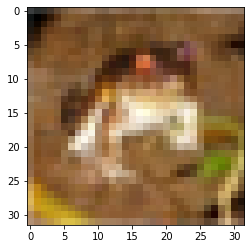

In [19]:
plt.imshow((x_train[0]+1)/2)

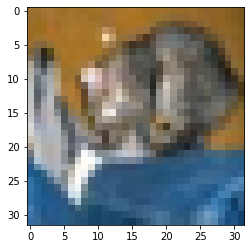

In [20]:
plt.imshow((x_test_normal[0]+1)/2)

In [21]:
x_train.shape

(45000, 32, 32, 3)

In [22]:
d_history = []
g_history = []

def train(x_train, n_epochs, n_batch, x_val=x_test_normal):
    n_train = x_train.shape[0]
    bat_per_epoch = int(x_train.shape[0] / n_batch)
    y_real = np.ones((n_batch,1))
    y_fake = np.zeros((n_batch,1))
    xhat_dummy = np.zeros((n_batch, )+ x_train.shape[1:]) # contextual lossの計算にわたすy_true=0
    z_dummy = np.zeros((n_batch,2,2,1024)) #Encoder_lossの計算
    
    for i in range(n_epochs):    
        for j in range(bat_per_epoch):
            #Real画像の生成
            #x_batch_0.shape, xhat_batch, x_batch=(32,32,32,3)
            #y_real,y_fake=(32,1) y_dummy=(32,100)
            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch_0 = x_train[idxes]
            
            #Fake画像の生成
            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch = x_train[idxes]
            z_batch = encoder.predict(x_batch)
            xhat_batch = decoder.predict(z_batch)
            
            d_loss = discriminator_train_step([x_batch_0, xhat_batch], [y_real, y_fake])
            d_history.append(d_loss)
            
            #xhat_dummy=(32,32,32,3)
            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch = x_train[idxes]
            g_loss = generator_train_step(x_batch, [y_real, xhat_dummy, z_dummy])
            g_history.append(g_loss)

            if j  == 0:
                print('epoch', i)
                print('D', d_loss[0], ', G', g_loss[0])
                print('D adv loss real', d_loss[1], ', D adv loss fake',  d_loss[2], )
                print('G adv loss', g_loss[1], 'G contextual loss', g_loss[2], 'G enc loss', g_loss[3])
                # 複数枚表示するようにした方が良い
                zhat_val = encoder.predict(x_val[:1])
                xhat_val = decoder.predict(zhat_val)
                plt.imshow((xhat_val[0,:,:,:]+1)/2)
                plt.axis("off")
                plt.show()
            # 5エポック以降は重みを保存
            if i>4:
                gan_G.save_weights(DATASET_PATH + '/GANomaly_%sepochs.h5' % i)

では学習です。本当はちゃんと`x_val`をつくって最後の引数に渡してください。

原論文に従い、15エポック学習させる：

epoch 0
D tf.Tensor(1.4722803, shape=(), dtype=float32) , G tf.Tensor(33.19028, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.92867637, shape=(), dtype=float32) , D adv loss fake tf.Tensor(0.5436039, shape=(), dtype=float32)
G adv loss tf.Tensor(0.93812454, shape=(), dtype=float32) G contextual loss tf.Tensor(0.6374899, shape=(), dtype=float32) G enc loss tf.Tensor(0.37765986, shape=(), dtype=float32)


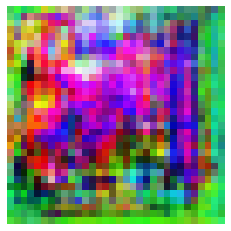

epoch 1
D tf.Tensor(2.5639582, shape=(), dtype=float32) , G tf.Tensor(20.879923, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9496633, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.6142948, shape=(), dtype=float32)
G adv loss tf.Tensor(0.22191985, shape=(), dtype=float32) G contextual loss tf.Tensor(0.41315976, shape=(), dtype=float32) G enc loss tf.Tensor(1.5145345e-05, shape=(), dtype=float32)


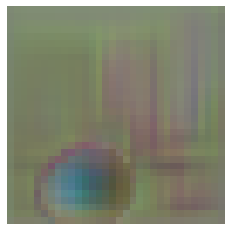

epoch 2
D tf.Tensor(2.572194, shape=(), dtype=float32) , G tf.Tensor(18.980331, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.97738236, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.5948117, shape=(), dtype=float32)
G adv loss tf.Tensor(0.26157457, shape=(), dtype=float32) G contextual loss tf.Tensor(0.3741265, shape=(), dtype=float32) G enc loss tf.Tensor(0.012431409, shape=(), dtype=float32)


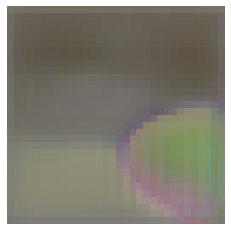

epoch 3
D tf.Tensor(3.1485968, shape=(), dtype=float32) , G tf.Tensor(16.238722, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9621974, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.1863995, shape=(), dtype=float32)
G adv loss tf.Tensor(0.1259117, shape=(), dtype=float32) G contextual loss tf.Tensor(0.32177293, shape=(), dtype=float32) G enc loss tf.Tensor(0.024164578, shape=(), dtype=float32)


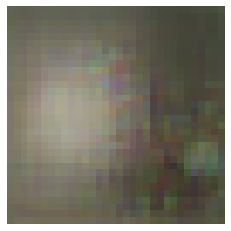

epoch 4
D tf.Tensor(3.2217107, shape=(), dtype=float32) , G tf.Tensor(12.7929535, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.93652165, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.2851892, shape=(), dtype=float32)
G adv loss tf.Tensor(0.11512481, shape=(), dtype=float32) G contextual loss tf.Tensor(0.2532238, shape=(), dtype=float32) G enc loss tf.Tensor(0.01663914, shape=(), dtype=float32)


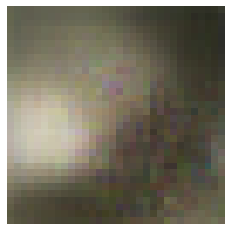

epoch 5
D tf.Tensor(3.315551, shape=(), dtype=float32) , G tf.Tensor(11.502004, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9355061, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.380045, shape=(), dtype=float32)
G adv loss tf.Tensor(0.10165635, shape=(), dtype=float32) G contextual loss tf.Tensor(0.22777684, shape=(), dtype=float32) G enc loss tf.Tensor(0.011506135, shape=(), dtype=float32)


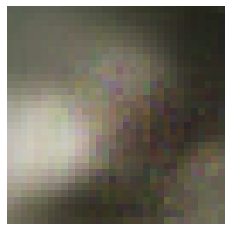

epoch 6
D tf.Tensor(3.27528, shape=(), dtype=float32) , G tf.Tensor(11.1774, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9310188, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.3442612, shape=(), dtype=float32)
G adv loss tf.Tensor(0.101307675, shape=(), dtype=float32) G contextual loss tf.Tensor(0.22130291, shape=(), dtype=float32) G enc loss tf.Tensor(0.010946099, shape=(), dtype=float32)


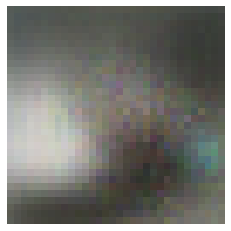

epoch 7
D tf.Tensor(3.3959188, shape=(), dtype=float32) , G tf.Tensor(10.623252, shape=(), dtype=float32)
D adv loss real tf.Tensor(1.0024099, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.393509, shape=(), dtype=float32)
G adv loss tf.Tensor(0.098707564, shape=(), dtype=float32) G contextual loss tf.Tensor(0.21038452, shape=(), dtype=float32) G enc loss tf.Tensor(0.0053185336, shape=(), dtype=float32)


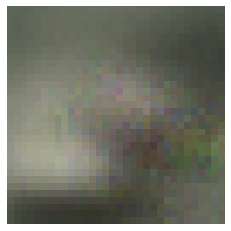

epoch 8
D tf.Tensor(3.2152371, shape=(), dtype=float32) , G tf.Tensor(9.773947, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.967831, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.247406, shape=(), dtype=float32)
G adv loss tf.Tensor(0.10487288, shape=(), dtype=float32) G contextual loss tf.Tensor(0.19328561, shape=(), dtype=float32) G enc loss tf.Tensor(0.0047935266, shape=(), dtype=float32)


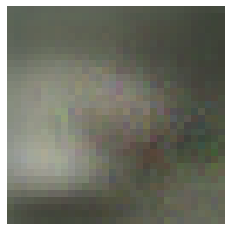

epoch 9
D tf.Tensor(3.2977774, shape=(), dtype=float32) , G tf.Tensor(9.253077, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9355884, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.362189, shape=(), dtype=float32)
G adv loss tf.Tensor(0.10547375, shape=(), dtype=float32) G contextual loss tf.Tensor(0.18287158, shape=(), dtype=float32) G enc loss tf.Tensor(0.0040232223, shape=(), dtype=float32)


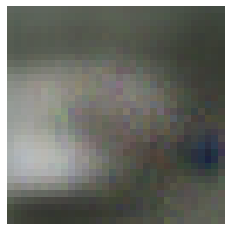

epoch 10
D tf.Tensor(3.2493305, shape=(), dtype=float32) , G tf.Tensor(9.511715, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9276528, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.3216777, shape=(), dtype=float32)
G adv loss tf.Tensor(0.10692976, shape=(), dtype=float32) G contextual loss tf.Tensor(0.18803144, shape=(), dtype=float32) G enc loss tf.Tensor(0.0032140338, shape=(), dtype=float32)


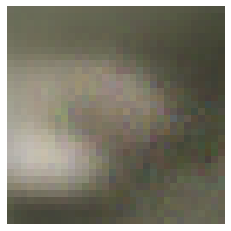

epoch 11
D tf.Tensor(3.332794, shape=(), dtype=float32) , G tf.Tensor(8.7392, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9887889, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.344005, shape=(), dtype=float32)
G adv loss tf.Tensor(0.08520906, shape=(), dtype=float32) G contextual loss tf.Tensor(0.17300496, shape=(), dtype=float32) G enc loss tf.Tensor(0.0037433456, shape=(), dtype=float32)


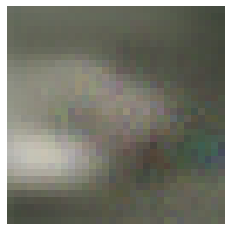

epoch 12
D tf.Tensor(3.0910525, shape=(), dtype=float32) , G tf.Tensor(8.63216, shape=(), dtype=float32)
D adv loss real tf.Tensor(1.0025605, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.0884922, shape=(), dtype=float32)
G adv loss tf.Tensor(0.107847765, shape=(), dtype=float32) G contextual loss tf.Tensor(0.17040463, shape=(), dtype=float32) G enc loss tf.Tensor(0.004080511, shape=(), dtype=float32)


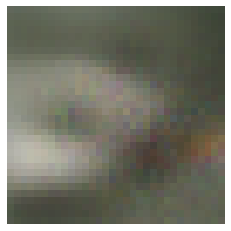

epoch 13
D tf.Tensor(3.2245421, shape=(), dtype=float32) , G tf.Tensor(8.6416235, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.95118964, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.2733526, shape=(), dtype=float32)
G adv loss tf.Tensor(0.1252716, shape=(), dtype=float32) G contextual loss tf.Tensor(0.17027082, shape=(), dtype=float32) G enc loss tf.Tensor(0.0028101536, shape=(), dtype=float32)


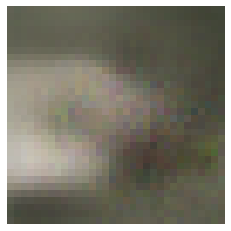

epoch 14
D tf.Tensor(3.0324705, shape=(), dtype=float32) , G tf.Tensor(8.764704, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9458119, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.0866585, shape=(), dtype=float32)
G adv loss tf.Tensor(0.11505253, shape=(), dtype=float32) G contextual loss tf.Tensor(0.17294347, shape=(), dtype=float32) G enc loss tf.Tensor(0.00247766, shape=(), dtype=float32)


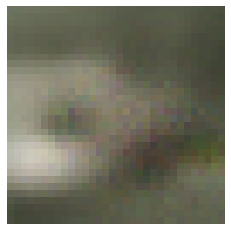

epoch 15
D tf.Tensor(3.1583812, shape=(), dtype=float32) , G tf.Tensor(9.016759, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9784712, shape=(), dtype=float32) , D adv loss fake tf.Tensor(2.17991, shape=(), dtype=float32)
G adv loss tf.Tensor(0.11878069, shape=(), dtype=float32) G contextual loss tf.Tensor(0.17789608, shape=(), dtype=float32) G enc loss tf.Tensor(0.0031733955, shape=(), dtype=float32)


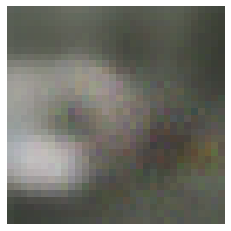

In [23]:
train(x_train, n_epochs=16, n_batch=32, x_val=x_test_normal)

学習曲線

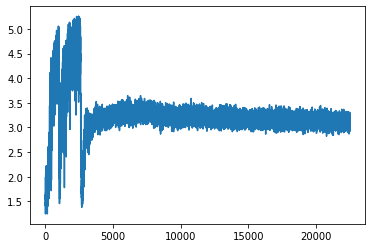

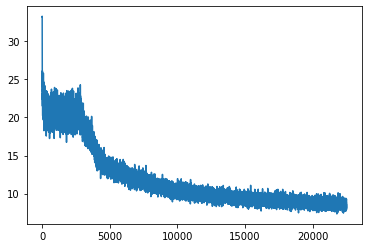

In [24]:
d_losses = np.array(d_history)[:,0]
g_losses = np.array(g_history)[:,0]

plt.plot(d_losses)
plt.show()

plt.plot(g_losses)
plt.show()

# 4. 学習済みモデルの評価

異常スコアを計算する関数を実装しておく：

In [25]:
def anomaly_score(x_batch, pred_model=gan_G, lam=0.9):
    _, x_subtruct, feat_subtruct = pred_model.predict(x_batch)
    R = np.mean(np.abs(x_subtruct), axis=(1,2,3))
    L = np.mean(feat_subtruct**2, axis=-1)
    A = lam*R + (1-lam)*L
    return A

早速、学習済みモデルをテストしてみよう。すぐさま過学習するので、エポック選択が重要だが、ここではsloppyにテストデータで見てしまおう（本当は検証データでエポック数を選ぶこと！! このように選んだ結果を論文に書いたら、これはモデル選択を介した典型的なスヌーピングです。）

<b>6エポック</b>

In [26]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_5epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

OSError: Unable to open file (unable to open file: name = './save_weight/GANomaly/skip_GANomaly_5epochs.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<b>7エポック</b>

In [ ]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_6epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

<b>8エポック</b>

In [ ]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_7epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

<b>9エポック</b>

In [ ]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_8epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

# 問題

学習済みの重み（7エポック）を配布したので、このモデルに対して異常検知のAUCを測りましょう。

また、y=0以外のクラスについても学習させ、異常カテゴリごとのAUCの違いを観察せよ（GANomalyなどの論文の結果と比べてみるとよい）。

またこの実装が原実装の細部を再現している保証はないので、詳しく調べてこのコードを改善せよ（そして調査結果を私に教えてください…）。